## Creating Custom Networks
In this notebook you have to create a custom network whose architecture has been given, and use the dataset you created earlier to train and test it.

In [24]:
# Import Statements
#
# Several of the imports you will need have been added but you will need to provide the
# rest yourself; you should be able to figure out most of the imports as you go through
# the notebook since without proper imports your code will fail to run
#
# All import statements go in this block

from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.utils.data
import torchvision.models as models
import torchvision.transforms as transforms
import glob
from torch.autograd import Variable
from PIL import Image
import torchvision
import torch.nn as nn

%matplotlib inline
import matplotlib.pyplot as plt

All hyper parameters go in the next block

In [25]:
batch_size = 100
num_epochs = 5
learning_rate = 0.001

### Create Custom Dataset and Loader
This is the same as part 1. Simply use the same code to create the dataset.

In [26]:
class CDATA(torch.utils.data.Dataset):
    def __init__(self, root_dir, train, transform=None):
        # root_dir  - the root directory of the dataset
        # train     - a boolean parameter representing whether to return the training set or the test set
        # transform - the transforms to be applied on the images before returning them
        #
        # In this function store the parameters in instance variables and make a mapping
        # from images to labels and keep it as an instance variable. Make sure to check which
        # dataset is required; train or test; and create the mapping accordingly.
        self.train = train
        self.transform = transform
        self.dataset = []
        tdir = "train"
        if train==False:
            tdir = "test"
        for filepath in glob.glob(root_dir+"/"+tdir+"/*/*.png"):
            label = ord(filepath.split("/")[-2]) - ord('A')
            with Image.open(filepath) as img:
                image = img.convert('RGB')
            self.dataset.append((image,label))
        
    def __len__(self):
        # return the size of the dataset (total number of images) as an integer
        # this should be rather easy if you created a mapping in __init__
        return len(self.dataset)
        
    def __getitem__(self, idx):
        # idx - the index of the sample requested
        #
        # Open the image correspoding to idx, apply transforms on it and return a tuple (image, label)
        # where label is an integer from 0-9 (since notMNIST has 10 classes)
        img, lab = self.dataset[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, lab
        
    
composed_transform = transforms.Compose([transforms.Scale((32,32)),transforms.ToTensor()])
train_dataset = CDATA(root_dir='../notMNIST_small', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = CDATA(root_dir='../notMNIST_small', train=False, transform=composed_transform) # Supply proper root_dir
print (len(train_dataset))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

16854


### Creating a Custom Network
It's time to create a new custom network. This network is based on Resnet (indeed it is a resnet since it uses skip connections). The architecture of the network is provided in the diagram. It specifies the layer names, layer types as well as their parameters.
<img src="architecture.png" width=100>
[Full size image](architecture.html)

In [27]:
class CustomResnet(nn.Module): # Extend PyTorch's Module class
    def __init__(self, num_classes = 10):
        super(CustomResnet, self).__init__() # Must call super __init__()
        
        # Define the layers of the network here
        # There should be 17 total layers as evident from the diagram
        # The parameters and names for the layers are provided in the diagram
        # The variable names have to be the same as the ones in the diagram
        # Otherwise, the weights will not load
        self.conv1 = nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3,bias=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        self.lyr1conv1 = nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1,bias=True)
        self.lyr1bn1 = nn.BatchNorm2d(64)
        self.lyr1relu1 = nn.ReLU(inplace=True)
        self.lyr1conv2 = nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1,bias=True)
        self.lyr1bn2 = nn.BatchNorm2d(64)
        self.lyr1relu2 = nn.ReLU(inplace=True)
        self.lyr2conv1 = nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1,bias=True)
        self.lyr2bn1 = nn.BatchNorm2d(64)
        self.lyr2relu1 = nn.ReLU(inplace=True)
        self.lyr2conv2 = nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1,bias=True)
        self.lyr2bn2 = nn.BatchNorm2d(64)
        self.lyr2relu2 = nn.ReLU(inplace=True)
        self.fc = nn.Linear(4096,num_classes)
        
    def forward(self, x):
        # Here you have to define the forward pass
        # Make sure you take care of the skip connections
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out1 = self.lyr1conv1(out)
        out1 = self.lyr1bn1(out1)
        out1 = self.lyr1relu1(out1)
        out1 = self.lyr1conv2(out1)
        out1 = self.lyr1bn2(out1)
        
        out = self.lyr1relu2(out1+out)
        
        out1 = self.lyr2conv1(out)
        out1 = self.lyr2bn1(out1)
        out1 = self.lyr2relu1(out1)
        out1 = self.lyr2conv2(out1)
        out1 = self.lyr2bn2(out1)
        
        out = self.lyr2relu2(out1+out)
        
        out = self.fc(out.view(-1,4096))
        return out

#### Finetune on pre-trained CIFAR-100 weights
We shall now finetune our model using pretrained CIFAR-100 weights.

In [28]:
model = CustomResnet(num_classes = 100) # 100 classes since CIFAR-100 has 100 classes

# Load CIFAR-100 weights. (Download them from assignment page)
# If network was properly implemented, weights should load without any problems
model.load_state_dict(torch.load('../CIFAR-100_weights')) # Supply the path to the weight file

##### Optional
As a sanity check you may load the CIFAR-100 test dataset and test the above model. You should get an accuracy of ~41%. This part is optional and is meant for your convenience.

In [ ]:
# Block for optionally running the model on CIFAR-100 test set

Let's finetune the model.

Epoch [1/5], Step [10/168], Loss: 0.8558
Epoch [1/5], Step [20/168], Loss: 0.4852
Epoch [1/5], Step [30/168], Loss: 0.3356
Epoch [1/5], Step [40/168], Loss: 0.2446
Epoch [1/5], Step [50/168], Loss: 0.2268
Epoch [1/5], Step [60/168], Loss: 0.3879
Epoch [1/5], Step [70/168], Loss: 0.3121
Epoch [1/5], Step [80/168], Loss: 0.2442
Epoch [1/5], Step [90/168], Loss: 0.3747
Epoch [1/5], Step [100/168], Loss: 0.2836
Epoch [1/5], Step [110/168], Loss: 0.1724
Epoch [1/5], Step [120/168], Loss: 0.1417
Epoch [1/5], Step [130/168], Loss: 0.3815
Epoch [1/5], Step [140/168], Loss: 0.2109
Epoch [1/5], Step [150/168], Loss: 0.1984
Epoch [1/5], Step [160/168], Loss: 0.2662
Epoch [2/5], Step [10/168], Loss: 0.3713
Epoch [2/5], Step [20/168], Loss: 0.2668
Epoch [2/5], Step [30/168], Loss: 0.2872
Epoch [2/5], Step [40/168], Loss: 0.3002
Epoch [2/5], Step [50/168], Loss: 0.2234
Epoch [2/5], Step [60/168], Loss: 0.1762
Epoch [2/5], Step [70/168], Loss: 0.0756
Epoch [2/5], Step [80/168], Loss: 0.1249
Epoch [2/

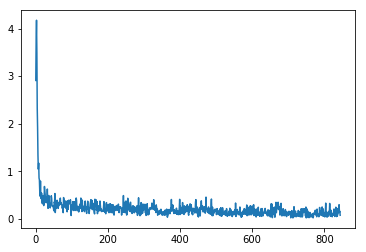

CPU times: user 35.7 s, sys: 8.76 s, total: 44.5 s
Wall time: 44.4 s


In [29]:
# Change last layer to output 10 classes since our dataset has 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)# Complete this statement. It is similar to the resnet18 case
if(torch.cuda.is_available()):
    model.cuda()
# Loss function and optimizers
criterion = nn.CrossEntropyLoss()# Define cross-entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)# Use Adam optimizer, use learning_rate hyper parameter

def train():
    # Code for training the model
    # Make sure to output a matplotlib graph of training losses
    llist = []
    count = 0
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            # Convert torch tensor to Variable
            images = Variable(images)
            labels = Variable(labels)
            images=images.cuda()
            labels=labels.cuda()
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            count = count+1
            llist.append(loss.data[0])
            if (i+1) % 10 == 0:
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
    plt.plot(np.array(range(count)),np.array(llist))
    plt.show()

%time train()

Test the finetuned model

In [30]:
def test():
    # Write loops for testing the model on the test set
    # You should also print out the accuracy of the model
    correct = 0
    total = 0
    
    for images, labels in test_loader:
        images = Variable(images)
        
        images = images.cuda()
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum()
    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
    
%time test()

Accuracy of the network on the test images: 92 %
CPU times: user 336 ms, sys: 96 ms, total: 432 ms
Wall time: 432 ms


#### Training from scratch
Now we shall try training the model from scratch and observe the differences.

Epoch [1/5], Step [10/168], Loss: 0.7306
Epoch [1/5], Step [20/168], Loss: 0.3058
Epoch [1/5], Step [30/168], Loss: 0.2881
Epoch [1/5], Step [40/168], Loss: 0.4845
Epoch [1/5], Step [50/168], Loss: 0.4254
Epoch [1/5], Step [60/168], Loss: 0.4671
Epoch [1/5], Step [70/168], Loss: 0.1627
Epoch [1/5], Step [80/168], Loss: 0.3578
Epoch [1/5], Step [90/168], Loss: 0.2830
Epoch [1/5], Step [100/168], Loss: 0.2811
Epoch [1/5], Step [110/168], Loss: 0.3349
Epoch [1/5], Step [120/168], Loss: 0.3531
Epoch [1/5], Step [130/168], Loss: 0.3248
Epoch [1/5], Step [140/168], Loss: 0.2677
Epoch [1/5], Step [150/168], Loss: 0.2184
Epoch [1/5], Step [160/168], Loss: 0.1871
Epoch [2/5], Step [10/168], Loss: 0.2089
Epoch [2/5], Step [20/168], Loss: 0.0812
Epoch [2/5], Step [30/168], Loss: 0.1122
Epoch [2/5], Step [40/168], Loss: 0.1015
Epoch [2/5], Step [50/168], Loss: 0.1432
Epoch [2/5], Step [60/168], Loss: 0.1154
Epoch [2/5], Step [70/168], Loss: 0.1375
Epoch [2/5], Step [80/168], Loss: 0.2043
Epoch [2/

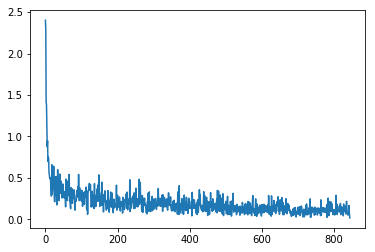

CPU times: user 34.7 s, sys: 8.38 s, total: 43.1 s
Wall time: 43 s
Accuracy of the network on the test images: 92 %
CPU times: user 380 ms, sys: 184 ms, total: 564 ms
Wall time: 420 ms


In [31]:
# Reinstantiate the model and optimizer
model = CustomResnet(num_classes = 10)
if(torch.cuda.is_available()):
    model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)# Use Adam optimizer, use learning_rate hyper parameter

# Train
%time train()

# Test
%time test()

This is the end of Assignment 1